# Tarea 4: ExPASy 
### <span style="color:blue"> Eduardo Alejandro Arrieta Donato</span> 
## índice
+ <a href="#Presentacion" style="color:pink">Presentación</a>
+ <a href="#Ejercicio_1" style="color:pink">Ejercicio 1</a>
+ <a href="#Ejercicio_2" style="color:pink">Ejercicio 2</a>
+ <a href="#Ejercicio_3" style="color:pink">Ejercicio 3</a>
+ <a href="#DONTCLICKME" style="color:pink">DON´T CLICKME</a>

<a id="Presentacion"></a>
## <span style="color:yellow"> Presentación</span>
Hola, esta es mi tarea4 del curso.

Cada ejercicio resulto viene con sus indicaciones generales y libertades que se tomaron.

Cada celda ocupada para resolver tendrá sus respectiva documentación de código.

## <span style="color:red"> README</span>
Esta tarea me costó mucho trabajo, pues se me aglomeraron varias cosas, desde académicas como personales y de equipo. Pues me quedé sin mi computadora personal por un buen periodo de tiempo, apenas pude conseguirla de vuelta. No fue la única materia en la que tuve problemas.

Muchas gracias por dejarme entregar la tarea después. Dos semanas de atraso si es una verdadera salvajada, por lo que acepto el castigo y penalización correspondiente.

<a id="Ejercicio_1"></a>

## <span style="color:yellow"> Ejercicio_1</span>
Busca los patrones de Prosite PS00079 y PS00080 en la Ferroxidasa humana HEPHL1 e imprme la o las partes de la secuencia que entra en el patron y el rango (donde inica y termina el patrón en la secuenca)

In [1]:
from Bio import Entrez 
from Bio import SeqIO
Entrez.email = 'earrieta@lcg.unam.mx'

# Realizo una busqueda del gen en NCBI con el filtro para humano
handle = Entrez.esearch(db="protein", term='HEPHL1[Gene] AND Homo Sapiens[Orgn]') 
record_busquueda = Entrez.read(handle) 
handle.close()

# Veo los resultados
record_busquueda['IdList']

['205785679', '148886707']

In [2]:
import re

# Como son más de uno los itero y busco el que tenga referencia con UniProt
for record in record_busquueda['IdList']:
    # Obtengo su gb
    handle_prot = Entrez.efetch(db="protein", id=record, rettype="gb", retmode="text")
    record_prot = SeqIO.read(handle_prot, "genbank")
    handle_prot.close()
    
    if 'UniProtKB' in record_prot.annotations['db_source']:
        # Extraigo su Entry de UniProt
        ID_UniProt = re.findall('accession (.*);', record_prot.annotations['db_source'])
        # Guardo el gb bueno
        gb_proteina = record_prot
    
    # Pueden existir más de un link a Uniprot, pero por lo general no hay redundancia en SwissProt

In [3]:
ID_UniProt

['Q6MZM0']

In [4]:
from Bio.ExPASy import ScanProsite

# Obtengo sus Prosites
handle_PS = ScanProsite.scan(seq= ID_UniProt[0])
result_PS = ScanProsite.read(handle_PS)

# Estos son los objetivos a imprimir
objetivos = ['PS00079','PS00080']

# Header
print('Prosite\tRango\tSequencia')
for prosite in result_PS:
    # Veo si están en mis objetivos
    if prosite['signature_ac'] in objetivos:
        # Obtengo su localización
        start = prosite['start']
        end = prosite['stop']
        # Imprimo la información
        print('{}\t{}-{}'.format(prosite['signature_ac'], start, end), end= '\t')
        print(gb_proteina.seq[start:end])

Prosite	Rango	Sequencia
PS00079	341-361	KWMITCQVSDHLQAGMLGQY
PS00079	694-714	IFRVFCATMPHLSRGMGQIY
PS00079	1043-1063	TWLLHCHVSDHIHAGMETTY
PS00080	1048-1059	CHVSDHIHAGM


<a id="Ejercicio_2"></a>

## <span style="color:yellow"> Ejercicio_2</span>
Obtén el nombre de las enzimas de una lista que contenga accesion numbers de SwissProt (los que quieras) utilizando expresiones regulares

<span style="color:green">La siguiente celda debe estra oculta, fue el parche de corrección para el modulo SwissProt de la librería de Biopython.</span>

In [5]:
# Copyright 2007 by Michiel de Hoon.  All rights reserved.
# This code is part of the Biopython distribution and governed by its
# license.  Please see the LICENSE file that should have been included
# as part of this package.
"""Code to work with the sprotXX.dat file from SwissProt.

https://web.expasy.org/docs/userman.html

Classes:
 - Record             Holds SwissProt data.
 - Reference          Holds reference data from a SwissProt record.

Functions:
 - read               Read one SwissProt record
 - parse              Read multiple SwissProt records

"""


import io

from Bio.SeqFeature import (
    SeqFeature,
    FeatureLocation,
    ExactPosition,
    BeforePosition,
    AfterPosition,
    UncertainPosition,
    UnknownPosition,
)


class SwissProtParserError(ValueError):
    """An error occurred while parsing a SwissProt file."""

    def __init__(self, *args, line=None):
        """Create a SwissProtParserError object with the offending line."""
        super().__init__(*args)
        self.line = line


class Record:
    """Holds information from a SwissProt record.

    Attributes:
     - entry_name        Name of this entry, e.g. RL1_ECOLI.
     - data_class        Either 'STANDARD' or 'PRELIMINARY'.
     - molecule_type     Type of molecule, 'PRT',
     - sequence_length   Number of residues.
     - accessions        List of the accession numbers, e.g. ['P00321']
     - created           A tuple of (date, release).
     - sequence_update   A tuple of (date, release).
     - annotation_update A tuple of (date, release).
     - description       Free-format description.
     - gene_name         Gene name.  See userman.txt for description.
     - organism          The source of the sequence.
     - organelle         The origin of the sequence.
     - organism_classification  The taxonomy classification.  List of strings.
       (http://www.ncbi.nlm.nih.gov/Taxonomy/)
     - taxonomy_id       A list of NCBI taxonomy id's.
     - host_organism     A list of names of the hosts of a virus, if any.
     - host_taxonomy_id  A list of NCBI taxonomy id's of the hosts, if any.
     - references        List of Reference objects.
     - comments          List of strings.
     - cross_references  List of tuples (db, id1[, id2][, id3]).  See the docs.
     - keywords          List of the keywords.
     - features          List of tuples (key name, from, to, description).
       from and to can be either integers for the residue
       numbers, '<', '>', or '?'
     - protein_existence Numerical value describing the evidence for the existence of the protein.
     - seqinfo           tuple of (length, molecular weight, CRC32 value)
     - sequence          The sequence.

    Examples
    --------
    >>> from Bio import SwissProt
    >>> example_filename = "SwissProt/sp008"
    >>> with open(example_filename) as handle:
    ...     records = SwissProt.parse(handle)
    ...     for record in records:
    ...         print(record.entry_name)
    ...         print(",".join(record.accessions))
    ...         print(record.keywords)
    ...         print(repr(record.organism))
    ...         print(record.sequence[:20] + "...")
    ...
    1A02_HUMAN
    P01892,P06338,P30514,P30444,P30445,P30446,Q29680,Q29899,Q95352,Q29837,Q95380
    ['MHC I', 'Transmembrane', 'Glycoprotein', 'Signal', 'Polymorphism', '3D-structure']
    'Homo sapiens (Human).'
    MAVMAPRTLVLLLSGALALT...

    """

    def __init__(self):
        """Initialize the class."""
        self.entry_name = None
        self.data_class = None
        self.molecule_type = None
        self.sequence_length = None

        self.accessions = []
        self.created = None
        self.sequence_update = None
        self.annotation_update = None

        self.description = []
        self.gene_name = ""
        self.organism = []
        self.organelle = ""
        self.organism_classification = []
        self.taxonomy_id = []
        self.host_organism = []
        self.host_taxonomy_id = []
        self.references = []
        self.comments = []
        self.cross_references = []
        self.keywords = []
        self.features = []
        self.protein_existence = ""

        self.seqinfo = None
        self.sequence = ""


class Reference:
    """Holds information from one reference in a SwissProt entry.

    Attributes:
     - number      Number of reference in an entry.
     - evidence    Evidence code.  List of strings.
     - positions   Describes extent of work.  List of strings.
     - comments    Comments.  List of (token, text).
     - references  References.  List of (dbname, identifier).
     - authors     The authors of the work.
     - title       Title of the work.
     - location    A citation for the work.

    """

    def __init__(self):
        """Initialize the class."""
        self.number = None
        self.positions = []
        self.comments = []
        self.references = []
        self.authors = []
        self.title = []
        self.location = []


class FeatureTable(SeqFeature):
    """Stores feature annotations for specific regions of the sequence.

    This is a subclass of SeqFeature, defined in Bio.SeqFeature, where the
    attributes are used as follows:

     - ``location``: location of the feature on the canonical or isoform
       sequence; the location is stored as an instance of FeatureLocation,
       defined in Bio.SeqFeature, with the ref attribute set to the isoform
       ID referring to the canonical or isoform sequence on which the feature
       is defined
     - ``id``: unique and stable identifier (FTId), only provided for features
       belonging to the types CARBOHYD, CHAIN, PEPTIDE, PROPEP, VARIANT, or
       VAR_SEQ
     - ``type``: indicates the type of feature, as defined by the UniProt
       Knowledgebase documentation:

        - ACT_SITE: amino acid(s) involved in the activity of an enzyme
        - BINDING:  binding site for any chemical group
        - CARBOHYD: glycosylation site; an FTId identifier to the GlyConnect
          database is provided if annotated there
        - CA_BIND:  calcium-binding region
        - CHAIN:    polypeptide chain in the mature protein
        - COILED:   coiled-coil region
        - COMPBIAS: compositionally biased region
        - CONFLICT: different sources report differing sequences
        - CROSSLNK: posttransationally formed amino acid bond
        - DISULFID: disulfide bond
        - DNA_BIND: DNA-binding region
        - DOMAIN:   domain, defined as a specific combination of secondary
          structures organized into a characteristic three-dimensional
          structure or fold
        - INIT_MET: initiator methionine
        - INTRAMEM: region located in a membrane without crossing it
        - HELIX:    alpha-, 3(10)-, or pi-helix secondary structure
        - LIPID:    covalent binding of a lipid moiety
        - METAL:    binding site for a metal ion
        - MOD_RES:  posttranslational modification (PTM) of a residue,
          annotated by the controlled vocabulary defined by the ptmlist.txt
          document on the UniProt website
        - MOTIF:    short sequence motif of biological interest
        - MUTAGEN:  site experimentally altered by mutagenesis
        - NON_CONS: non-consecutive residues
        - NON_STD:  non-standard amino acid
        - NON_TER:  the residue at an extremity of the sequence is not the
          terminal residue
        - NP_BIND:  nucleotide phosphate-binding region
        - PEPTIDE:  released active mature polypeptide
        - PROPEP:   any processed propeptide
        - REGION:   region of interest in the sequence
        - REPEAT:   internal sequence repetition
        - SIGNAL:   signal sequence (prepeptide)
        - SITE:     amino-acid site of interest not represented by another
          feature key
        - STRAND:   beta-strand secondary structure; either a hydrogen-bonded
          extended beta strand or a residue in an isolated beta-bridge
        - TOPO_DOM: topological domain
        - TRANSIT:  transit peptide (mitochondrion, chloroplast, thylakoid,
          cyanelle, peroxisome, etc.)
        - TRANSMEM: transmembrane region
        - TURN:     H-bonded turn (3-, 4-, or 5-turn)
        - UNSURE:   uncertainties in the sequence
        - VARIANT:  sequence variant; an FTId is provided for protein sequence
          variants of Hominidae (great apes and humans)
        - VAR_SEQ:  sequence variant produced by alternative splicing,
          alternative promoter usage, alternative initiation, or ribosomal
          frameshifting
        - ZN_FING:  zinc finger region

     - qualifiers   A dictionary of additional information, which may include
       the feature evidence and free-text notes. While SwissProt includes the
       feature identifier code (FTId) as a qualifier, it is stored as the
       attribute ID of the FeatureTable object.

    """


def parse(source):
    """Read multiple SwissProt records from file.

    Argument source is a file-like object or a path to a file.

    Returns a generator object which yields Bio.SwissProt.Record() objects.
    """
    handle = _open(source)
    try:
        while True:
            record = _read(handle)
            if not record:
                return
            yield record
    finally:
        if handle is not source:
            handle.close()


def read(source):
    """Read one SwissProt record from file.

    Argument source is a file-like object or a path to a file.

    Returns a Record() object.
    """
    handle = _open(source)
    try:
        record = _read(handle)
        if not record:
            raise ValueError("No SwissProt record found")
        # We should have reached the end of the record by now.
        # Try to read one more line to be sure:
        try:
            next(handle)
        except StopIteration:
            return record
        raise ValueError("More than one SwissProt record found")
    finally:
        if handle is not source:
            handle.close()


# Everything below is considered private


def _open(source):
    try:
        handle = open(source)
        return handle
    except TypeError:
        handle = source
        if handle.read(0) == "":
            # handle is text; assume the encoding is compatible with ASCII
            return handle
        # handle is binary; SwissProt encoding is always ASCII
        return io.TextIOWrapper(handle, encoding="ASCII")


def _read(handle):
    record = None
    unread = ""
    try:
        line = next(handle)
    except StopIteration:
        return record
    key, value = line[:2], line[5:].rstrip()
    if key != "ID":
        raise SwissProtParserError("Failed to find ID in first line", line=line)
    record = Record()
    _read_id(record, line)
    _sequence_lines = []
    for line in handle:
        key, value = line[:2], line[5:].rstrip()
        if unread:
            value = unread + " " + value
            unread = ""
        if key == "AC":
            accessions = value.rstrip(";").split("; ")
            record.accessions.extend(accessions)
        elif key == "DT":
            _read_dt(record, line)
        elif key == "DE":
            record.description.append(value.strip())
        elif key == "GN":
            if record.gene_name:
                record.gene_name += " "
            record.gene_name += value
        elif key == "OS":
            record.organism.append(value)
        elif key == "OG":
            record.organelle += line[5:]
        elif key == "OC":
            cols = value.rstrip(";.").split("; ")
            record.organism_classification.extend(cols)
        elif key == "OX":
            _read_ox(record, line)
        elif key == "OH":
            _read_oh(record, line)
        elif key == "RN":
            reference = Reference()
            _read_rn(reference, value)
            record.references.append(reference)
        elif key == "RP":
            assert record.references, "RP: missing RN"
            record.references[-1].positions.append(value)
        elif key == "RC":
            assert record.references, "RC: missing RN"
            reference = record.references[-1]
            unread = _read_rc(reference, value)
        elif key == "RX":
            assert record.references, "RX: missing RN"
            reference = record.references[-1]
            _read_rx(reference, value)
        elif key == "RL":
            assert record.references, "RL: missing RN"
            reference = record.references[-1]
            reference.location.append(value)
        # In UniProt release 1.12 of 6/21/04, there is a new RG
        # (Reference Group) line, which references a group instead of
        # an author.  Each block must have at least 1 RA or RG line.
        elif key == "RA":
            assert record.references, "RA: missing RN"
            reference = record.references[-1]
            reference.authors.append(value)
        elif key == "RG":
            assert record.references, "RG: missing RN"
            reference = record.references[-1]
            reference.authors.append(value)
        elif key == "RT":
            assert record.references, "RT: missing RN"
            reference = record.references[-1]
            reference.title.append(value)
        elif key == "CC":
            _read_cc(record, line)
        elif key == "DR":
            _read_dr(record, value)
        elif key == "PE":
            _read_pe(record, value)
        elif key == "KW":
            _read_kw(record, value)
        elif key == "FT":
            _read_ft(record, line)
        elif key == "SQ":
            cols = value.split()
            assert len(cols) == 7, "I don't understand SQ line %s" % line
            # Do more checking here?
            record.seqinfo = int(cols[1]), int(cols[3]), cols[5]
        elif key == "  ":
            _sequence_lines.append(value.replace(" ", "").rstrip())
        elif key == "//":
            # Join multiline data into one string
            record.description = " ".join(record.description)
            record.organism = " ".join(record.organism)
            record.organelle = record.organelle.rstrip()
            for reference in record.references:
                reference.authors = " ".join(reference.authors).rstrip(";")
                if reference.title:
                    title = reference.title[0]
                    for fragment in reference.title[1:]:
                        if not title.endswith("-"):
                            title += " "
                        title += fragment
                    title = title.rstrip(";")
                    if title.startswith('"') and title.endswith('"'):
                        title = title[1:-1]  # remove quotes
                else:
                    title = ""
                reference.title = title
                reference.location = " ".join(reference.location)
            record.sequence = "".join(_sequence_lines)
            return record
        elif key == "**":
            # Do this one last, as it will almost never occur.
            # See Bug 2353, some files from the EBI have extra lines
            # starting "**" (two asterisks/stars).  They appear
            # to be unofficial automated annotations. e.g.
            # **
            # **   #################    INTERNAL SECTION    ##################
            # **HA SAM; Annotated by PicoHamap 1.88; MF_01138.1; 09-NOV-2003.
            pass
        else:
            raise SwissProtParserError("Unknown keyword '%s' found" % key, line=line)
    if record:
        raise ValueError("Unexpected end of stream.")


def _read_id(record, line):
    cols = line[5:].split()
    # Prior to release 51, included with MoleculeType:
    # ID   EntryName DataClass; MoleculeType; SequenceLength AA.
    #
    # Newer files lack the MoleculeType:
    # ID   EntryName DataClass; SequenceLength AA.
    if len(cols) == 5:
        record.entry_name = cols[0]
        record.data_class = cols[1].rstrip(";")
        record.molecule_type = cols[2].rstrip(";")
        record.sequence_length = int(cols[3])
    elif len(cols) == 4:
        record.entry_name = cols[0]
        record.data_class = cols[1].rstrip(";")
        record.molecule_type = None
        record.sequence_length = int(cols[2])
    else:
        raise SwissProtParserError("ID line has unrecognised format", line=line)
    # check if the data class is one of the allowed values
    allowed = ("STANDARD", "PRELIMINARY", "IPI", "Reviewed", "Unreviewed")
    if record.data_class not in allowed:
        message = "Unrecognized data class '%s'" % record.data_class
        raise SwissProtParserError(message, line=line)

    # molecule_type should be 'PRT' for PRoTein
    # Note that has been removed in recent releases (set to None)
    if record.molecule_type not in (None, "PRT"):
        message = "Unrecognized molecule type '%s'" % record.molecule_type
        raise SwissProtParserError(message, line=line)


def _read_dt(record, line):
    value = line[5:]
    uprline = value.upper()
    cols = value.rstrip().split()
    if (
        "CREATED" in uprline
        or "LAST SEQUENCE UPDATE" in uprline
        or "LAST ANNOTATION UPDATE" in uprline
    ):
        # Old style DT line
        # =================
        # e.g.
        # DT   01-FEB-1995 (Rel. 31, Created)
        # DT   01-FEB-1995 (Rel. 31, Last sequence update)
        # DT   01-OCT-2000 (Rel. 40, Last annotation update)
        #
        # or:
        # DT   08-JAN-2002 (IPI Human rel. 2.3, Created)
        # ...

        # find where the version information will be located
        # This is needed for when you have cases like IPI where
        # the release version is in a different spot:
        # DT   08-JAN-2002 (IPI Human rel. 2.3, Created)
        uprcols = uprline.split()
        rel_index = -1
        for index in range(len(uprcols)):
            if "REL." in uprcols[index]:
                rel_index = index
        assert rel_index >= 0, "Could not find Rel. in DT line: %s" % line
        version_index = rel_index + 1
        # get the version information
        str_version = cols[version_index].rstrip(",")
        # no version number
        if str_version == "":
            version = 0
        # dot versioned
        elif "." in str_version:
            version = str_version
        # integer versioned
        else:
            version = int(str_version)
        date = cols[0]

        if "CREATED" in uprline:
            record.created = date, version
        elif "LAST SEQUENCE UPDATE" in uprline:
            record.sequence_update = date, version
        elif "LAST ANNOTATION UPDATE" in uprline:
            record.annotation_update = date, version
        else:
            raise SwissProtParserError("Unrecognised DT (DaTe) line", line=line)
    elif (
        "INTEGRATED INTO" in uprline
        or "SEQUENCE VERSION" in uprline
        or "ENTRY VERSION" in uprline
    ):
        # New style DT line
        # =================
        # As of UniProt Knowledgebase release 7.0 (including
        # Swiss-Prot release 49.0 and TrEMBL release 32.0) the
        # format of the DT lines and the version information
        # in them was changed - the release number was dropped.
        #
        # For more information see bug 1948 and
        # http://ca.expasy.org/sprot/relnotes/sp_news.html#rel7.0
        #
        # e.g.
        # DT   01-JAN-1998, integrated into UniProtKB/Swiss-Prot.
        # DT   15-OCT-2001, sequence version 3.
        # DT   01-APR-2004, entry version 14.
        #
        # This is a new style DT line...

        # The date should be in string cols[1]
        # Get the version number if there is one.
        # For the three DT lines above: 0, 3, 14
        try:
            version = 0
            for s in cols[-1].split("."):
                if s.isdigit():
                    version = int(s)
        except ValueError:
            version = 0
        date = cols[0].rstrip(",")

        # Re-use the historical property names, even though
        # the meaning has changed slighty:
        if "INTEGRATED" in uprline:
            record.created = date, version
        elif "SEQUENCE VERSION" in uprline:
            record.sequence_update = date, version
        elif "ENTRY VERSION" in uprline:
            record.annotation_update = date, version
        else:
            raise SwissProtParserError("Unrecognised DT (DaTe) line", line=line)
    else:
        raise SwissProtParserError("Failed to parse DT (DaTe) line", line=line)


def _read_ox(record, line):
    # The OX line used to be in the simple format:
    # OX   DESCRIPTION=ID[, ID]...;
    # If there are too many id's to fit onto a line, then the ID's
    # continue directly onto the next line, e.g.
    # OX   DESCRIPTION=ID[, ID]...
    # OX   ID[, ID]...;
    # Currently, the description is always "NCBI_TaxID".
    # To parse this, I need to check to see whether I'm at the
    # first line.  If I am, grab the description and make sure
    # it's an NCBI ID.  Then, grab all the id's.
    #
    # As of the 2014-10-01 release, there may be an evidence code, e.g.
    # OX   NCBI_TaxID=418404 {ECO:0000313|EMBL:AEX14553.1};
    # In the short term, we will ignore any evidence codes:
    line = line.split("{")[0]
    if record.taxonomy_id:
        ids = line[5:].rstrip().rstrip(";")
    else:
        descr, ids = line[5:].rstrip().rstrip(";").split("=")
        assert descr == "NCBI_TaxID", "Unexpected taxonomy type %s" % descr
    record.taxonomy_id.extend(ids.split(", "))


def _read_oh(record, line):
    # Line type OH (Organism Host) for viral hosts
    assert line[5:].startswith("NCBI_TaxID="), "Unexpected %s" % line
    line = line[16:].rstrip()
    assert line[-1] == "." and line.count(";") == 1, line
    taxid, name = line[:-1].split(";")
    record.host_taxonomy_id.append(taxid.strip())
    record.host_organism.append(name.strip())


def _read_rn(reference, rn):
    # This used to be a very simple line with a reference number, e.g.
    # RN   [1]
    # As of the 2014-10-01 release, there may be an evidence code, e.g.
    # RN   [1] {ECO:0000313|EMBL:AEX14553.1}
    words = rn.split(None, 1)
    number = words[0]
    assert number.startswith("[") and number.endswith("]"), (
        "Missing brackets %s" % number
    )
    reference.number = int(number[1:-1])
    if len(words) > 1:
        evidence = words[1]
        assert evidence.startswith("{") and evidence.endswith("}"), (
            "Missing braces %s" % evidence
        )
        reference.evidence = evidence[1:-1].split("|")


def _read_rc(reference, value):
    cols = value.split(";")
    if value[-1] == ";":
        unread = ""
    else:
        cols, unread = cols[:-1], cols[-1]
    for col in cols:
        if not col:  # last column will be the empty string
            return
        # The token is everything before the first '=' character.
        i = col.find("=")
        if i >= 0:
            token, text = col[:i], col[i + 1 :]
            comment = token.lstrip(), text
            reference.comments.append(comment)
        else:
            comment = reference.comments[-1]
            comment = "%s %s" % (comment, col)
            reference.comments[-1] = comment
    return unread


def _read_rx(reference, value):
    # The basic (older?) RX line is of the form:
    # RX   MEDLINE; 85132727.
    # but there are variants of this that need to be dealt with (see below)

    # CLD1_HUMAN in Release 39 and DADR_DIDMA in Release 33
    # have extraneous information in the RX line.  Check for
    # this and chop it out of the line.
    # (noticed by katel@worldpath.net)
    value = value.replace(" [NCBI, ExPASy, Israel, Japan]", "")

    # RX lines can also be used of the form
    # RX   PubMed=9603189;
    # reported by edvard@farmasi.uit.no
    # and these can be more complicated like:
    # RX   MEDLINE=95385798; PubMed=7656980;
    # RX   PubMed=15060122; DOI=10.1136/jmg 2003.012781;
    # We look for these cases first and deal with them
    warn = False
    if "=" in value:
        cols = value.split("; ")
        cols = [x.strip() for x in cols]
        cols = [x for x in cols if x]
        for col in cols:
            x = col.split("=")
            if len(x) != 2 or x == ("DOI", "DOI"):
                warn = True
                break
            assert len(x) == 2, "I don't understand RX line %s" % value
            reference.references.append((x[0], x[1].rstrip(";")))
    # otherwise we assume we have the type 'RX   MEDLINE; 85132727.'
    else:
        cols = value.split("; ")
        # normally we split into the three parts
        if len(cols) != 2:
            warn = True
        else:
            reference.references.append((cols[0].rstrip(";"), cols[1].rstrip(".")))
    if warn:
        import warnings
        from Bio import BiopythonParserWarning

        warnings.warn("Possibly corrupt RX line %r" % value, BiopythonParserWarning)


def _read_cc(record, line):
    key, value = line[5:8], line[9:].rstrip()
    if key == "-!-":  # Make a new comment
        record.comments.append(value)
    elif key == "   ":  # add to the previous comment
        if not record.comments:
            # TCMO_STRGA in Release 37 has comment with no topic
            record.comments.append(value)
        else:
            record.comments[-1] += " " + value


def _read_dr(record, value):
    cols = value.rstrip(".").split("; ")
    record.cross_references.append(tuple(cols))


def _read_pe(record, value):
    pe = value.split(":")
    record.protein_existence = int(pe[0])


def _read_kw(record, value):
    # Old style - semi-colon separated, multi-line. e.g. Q13639.txt
    # KW   Alternative splicing; Cell membrane; Complete proteome;
    # KW   Disulfide bond; Endosome; G-protein coupled receptor; Glycoprotein;
    # KW   Lipoprotein; Membrane; Palmitate; Polymorphism; Receptor; Transducer;
    # KW   Transmembrane.
    #
    # New style as of 2014-10-01 release with evidence codes, e.g. H2CNN8.txt
    # KW   Monooxygenase {ECO:0000313|EMBL:AEX14553.1};
    # KW   Oxidoreductase {ECO:0000313|EMBL:AEX14553.1}.
    # For now to match the XML parser, drop the evidence codes.
    for value in value.rstrip(";.").split("; "):
        if value.endswith("}"):
            # Discard the evidence code
            value = value.rsplit("{", 1)[0]
        record.keywords.append(value.strip())


def _read_ft(record, line):
    name = line[5:13].rstrip()
    if name:
        if line[13:21] == "        ":  # new-style FT line
            location = line[21:80].rstrip()
            try:
                isoform_id, location = location.split(":")
            except ValueError:
                isoform_id = None
            try:
                from_res, to_res = location.split("..")
            except ValueError:
                from_res = location
                to_res = ""
            qualifiers = {}
        else:  # old-style FT line
            from_res = line[14:20].lstrip()
            to_res = line[21:27].lstrip()
            isoform_id = None
            description = line[34:75].rstrip()
            qualifiers = {"description": description}
        if from_res == "?":
            from_res = UnknownPosition()
        elif from_res.startswith("?"):
            position = int(from_res[1:]) - 1  # Python zero-based counting
            from_res = UncertainPosition(position)
        elif from_res.startswith("<"):
            position = int(from_res[1:]) - 1  # Python zero-based counting
            from_res = BeforePosition(position)
        else:
            position = int(from_res) - 1  # Python zero-based counting
            from_res = ExactPosition(position)
        if to_res == "":
            position = from_res + 1
            to_res = ExactPosition(position)
        elif to_res == "?":
            to_res = UnknownPosition()
        elif to_res.startswith("?"):
            position = int(to_res[1:])
            to_res = UncertainPosition(position)
        elif to_res.startswith(">"):
            position = int(to_res[1:])
            to_res = AfterPosition(position)
        else:
            position = int(to_res)
            to_res = ExactPosition(position)
        location = FeatureLocation(from_res, to_res, ref=isoform_id)
        feature = FeatureTable(
            location=location, type=name, id=None, qualifiers=qualifiers
        )
        record.features.append(feature)
        return
    # this line is a continuation of the previous feature
    feature = record.features[-1]
    if line[5:34] == "                             ":  # old-style FT line
        description = line[34:75].rstrip()
        if description.startswith("/FTId="):
            # store the FTId as the feature ID
            feature.id = description[6:].rstrip(".")
            return
        # this line is a continuation of the description of the previous feature
        old_description = feature.qualifiers["description"]
        if old_description.endswith("-"):
            description = "%s%s" % (old_description, description)
        else:
            description = "%s %s" % (old_description, description)

        if feature.type in ("VARSPLIC", "VAR_SEQ"):  # special case
            # Remove unwanted spaces in sequences.
            # During line carryover, the sequences in VARSPLIC/VAR_SEQ can get
            # mangled with unwanted spaces like:
            # 'DISSTKLQALPSHGLESIQT -> PCRATGWSPFRRSSPC LPTH'
            # We want to check for this case and correct it as it happens.
            try:
                first_seq, second_seq = description.split(" -> ")
            except ValueError:
                pass
            else:
                extra_info = ""
                # we might have more information at the end of the
                # second sequence, which should be in parenthesis
                extra_info_pos = second_seq.find(" (")
                if extra_info_pos != -1:
                    extra_info = second_seq[extra_info_pos:]
                    second_seq = second_seq[:extra_info_pos]
                # now clean spaces out of the first and second string
                first_seq = first_seq.replace(" ", "")
                second_seq = second_seq.replace(" ", "")
                # reassemble the description
                description = first_seq + " -> " + second_seq + extra_info
        feature.qualifiers["description"] = description
    else:  # new-style FT line
        value = line[21:].rstrip()
        if value.startswith("/id="):
            qualifier_type = "id"
            value = value[4:]
            assert value.startswith('"')
            assert value.endswith('"')
            feature.id = value[1:-1]
            return
        elif value.startswith("/evidence="):
            value = value[10:]
            assert value.startswith('"')
            if value.endswith('"'):
                value = value[1:-1]
            else:  # continues on the next line
                value = value[1:]
            assert "evidence" not in feature.qualifiers
            feature.qualifiers["evidence"] = value
            return
        elif value.startswith("/note="):
            value = value[6:]
            assert value.startswith('"')
            if value.endswith('"'):
                value = value[1:-1]
            else:  # continues on the next line
                value = value[1:]
            assert "note" not in feature.qualifiers
            feature.qualifiers["note"] = value
            return
        # this line is a continuation of the description of the previous feature
        keys = list(feature.qualifiers.keys())
        key = keys[-1]
        description = value.rstrip('"')
        old_description = feature.qualifiers[key]
        if key == "evidence" or old_description.endswith("-"):
            description = "%s%s" % (old_description, description)
        else:
            description = "%s %s" % (old_description, description)
        if feature.type == "VAR_SEQ":  # see VARSPLIC above
            try:
                first_seq, second_seq = description.split(" -> ")
            except ValueError:
                pass
            else:
                extra_info = ""
                # we might have more information at the end of the
                # second sequence, which should be in parenthesis
                extra_info_pos = second_seq.find(" (")
                if extra_info_pos != -1:
                    extra_info = second_seq[extra_info_pos:]
                    second_seq = second_seq[:extra_info_pos]
                # now clean spaces out of the first and second string
                first_seq = first_seq.replace(" ", "")
                second_seq = second_seq.replace(" ", "")
                # reassemble the description
                description = first_seq + " -> " + second_seq + extra_info
        feature.qualifiers[key] = description




In [6]:
import re
import urllib
from Bio import ExPASy
from Bio import SwissProt
from Bio.ExPASy import Enzyme

# Las Entry de UniProt a buscar su información como enzima
Entrys_UP = ['Q9Y5Q5', 'P62837', 'P49427', 'P61077', 'P51668', 'P61086', 'P61085']

# Header
print('UP_Entry\tID_Enzyme\tName')

# Recorre los Entrys para buscarlos en SwissProt
for Entry in Entrys_UP:
    with ExPASy.get_sprot_raw(Entry) as handle_UP:
        record_UP = read(handle_UP)
    
    # Obtiene su EC number con expresiones regulares
    ECs = re.findall('EC=([\d.-]*)', record_UP.description)
    
    # Recorrerá cada resultado encontrado en la descripción
    for EC in ECs:
        # Abrirá su pagina correspondiente en Ezyme
        with urllib.request.urlopen('https://enzyme.expasy.org/EC/{}.txt'.format(EC)) as handle_EZ:
            with io.TextIOWrapper(handle_EZ, encoding='cp1252') as wrapped_handle:     
                record_EZ = Enzyme.read(wrapped_handle)
        
        # Algunas proteínas pueden no tener una clasificación específica por lo que
        # Si existe la página imprimirá los resultados
        if record_EZ:
            print(f'{Entry}\t{record_EZ["ID"]}\t{record_EZ["DE"]}')
        # Si no existe, mandará la pagina para buscar más información
        else:
            print(f'{Entry}\t{EC}\tInformationNotEspecific... see at https://enzyme.expasy.org/EC/{EC}')

UP_Entry	ID_Enzyme	Name
Q9Y5Q5	3.4.21.-	InformationNotEspecific... see at https://enzyme.expasy.org/EC/3.4.21.-
P62837	2.3.2.23	E2 ubiquitin-conjugating enzyme.
P62837	2.3.2.24	(E3-independent) E2 ubiquitin-conjugating enzyme.
P49427	2.3.2.23	E2 ubiquitin-conjugating enzyme.
P49427	2.3.2.24	(E3-independent) E2 ubiquitin-conjugating enzyme.
P61077	2.3.2.23	E2 ubiquitin-conjugating enzyme.
P61077	2.3.2.24	(E3-independent) E2 ubiquitin-conjugating enzyme.
P51668	2.3.2.23	E2 ubiquitin-conjugating enzyme.
P51668	2.3.2.24	(E3-independent) E2 ubiquitin-conjugating enzyme.
P61086	2.3.2.23	E2 ubiquitin-conjugating enzyme.
P61085	2.3.2.23	E2 ubiquitin-conjugating enzyme.


<a id="Ejercicio_3"></a>

## <span style="color:yellow"> Ejercicio_3</span>
Escojan un organismo de los presentes en Cellosaurus y después escojan una categoría para graficar los porcentajes.

Por ejemplo, en la categoría de enfermedades cuáles son las más representadas o en sexo cuáles son los porcentajes (x% mixed sex, y% female, z% male)

<span style="color:green">Para esta actividad se decidió plotear las lineas celulares decidas a la trucha arcoíris *(Oncorhynchus mykiss)* de acuerdo al sexo al que corresponde. Esta especie está bajo una fuerte ameneza patológica y es de importancia económica en el país, aparte, es el organismo que estoy usando para mi proyecto de celular.</span>
### <span style="color:blue">*(Oncorhynchus mykiss)*</span>
![Aqui está la trucha](https://beneficioss.com/wp-content/uploads/2018/06/1200px-Oncorhynchus_mykiss_opt.jpg)

In [7]:
from Bio.ExPASy import cellosaurus 

# Parseamos el archivo
with open('../tmp/cellosaurus.txt') as handle_cell:
    records_cell = cellosaurus.parse(handle_cell)    
    # Obtenemos los ID de cada linea celular de la trucha arcoíris
    cellsLines = [record['ID'] for record in records_cell if 'Oncorhynchus mykiss' in record["OX"][0]]

# Las vemos en pantalla
print(cellsLines, '\n\nNumero de lineas:', len(cellsLines))

['11B', '23B2', '24BC', '25B', '26B', '49B2', '58B2C', '5C2', '6B [Oncorhynchus]', 'Fin-4', 'Fr994', 'HK1532', 'mRTP1B', 'mRTP1E', 'mRTP1F', 'mRTP1K', 'mRTP2A', 'RBTE 45', 'RT [Oncorhynchus]', 'RT-milt5', 'RT-ovf1', 'RT-testis', 'RTBrain', 'RTE [Carp embryo]', 'RTE [Carp eye]', 'RTE-2', 'RTee', 'RTG-2', 'RTG-2/f', 'RTG-P1', 'RTgill-W1', 'RTgill-W1-pf', 'RTgutF', 'RTgutGC', 'RTH', 'RTH-149', 'RTH1B1A', 'RTH1B1D', 'RTH1B2A', 'RTH1B2C', 'RTHDF', 'RTK [Carp kidney]', 'RTL-4', 'RTL-W1', 'RTM', 'RTO', 'RTO-2', 'RTP-2', 'RTP-91E', 'RTP-91F', 'RTS', 'RTS11', 'RTS11-GFP', 'RTS34', 'RTS34st', 'RTS34st(neo)', 'RTT', 'SOB-15', 'STE-137', 'TPS', 'TPS-2', 'TSS'] 

Numero de lineas: 62


In [8]:
# Conteo por sexo
Male = 0
Female = 0
Unspecified = 0

with open('../tmp/cellosaurus.txt') as handle_cell:
    records_cell = cellosaurus.parse(handle_cell)
    for record in records_cell:
        if 'Oncorhynchus mykiss' in record["OX"][0]:
            if record['SX'] == 'Female':
                Female += 1
            elif record['SX'] == 'Male':
                Male += 1
            else:
                Unspecified += 1
    print(Female, Male, Unspecified)    

14 6 42


In [9]:
# Sacamos porcentajes
Male = (Male*100)/len(cellsLines)
Female = (Female*100)/len(cellsLines)
Unspecified = (Unspecified*100)/len(cellsLines)

print(Female, Male, Unspecified)

22.580645161290324 9.67741935483871 67.74193548387096


<span style="color:green">El ploteo se generó con el código que proporciona la librería matplotlib.</span>

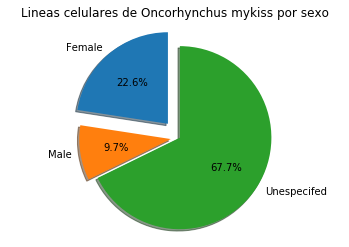

In [10]:
# Ploteo
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Female', 'Male', 'Unespecifed']
sizes = [Female, Male, Unspecified]
explode = (0.2, 0.1, 0.0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Lineas celulares de Oncorhynchus mykiss por sexo')

plt.show()

<a id="DONTCLICKME"></a>
## <span style="color:yellow"> CHOMP!</span>
![Te dije que no le dieras clic](https://m.gifanimados.com/Gifs-Animales/Animaciones-Animales-Marinos/Peces/Tiburones/Boca-Tiburon-69162.gif)